# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [1]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [2]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [3]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [ ]:
X_train, Y_train = generate_dataset(12000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

Y_train_target = np.expand_dims(Y_train, -1)
Y_val_target = np.expand_dims(Y_val, -1)

In [ ]:
i =  np.random.randint(10000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

9300
infix :  ( d - e )
posfix notation:  d e -
teacher forcing :  SOS d e -


# Model Creation - RNN with attention layer

We design an encoder-decoder model using recurrent neural networks with an integrated attention mechanism.

Although Transformer-based models have become state-of-the-art for many NLP tasks due to their capacity for handling long-range dependencies and parallel processing, our task — converting symbolic formulas (e.g., infix to postfix) — involves sequences of limited length, bounded by a maximum depth of 3. Therefore, the high capacity of Transformers is unnecessary and would introduce additional computational overhead without significant performance gain.

Recurrent neural networks, particularly in an encoder-decoder configuration, are well-suited for handling short sequences and learning sequential transformations. To further enhance the model’s capacity, we incorporate an attention mechanism. Even in short sequences, attention allows the decoder to dynamically focus on relevant parts of the input, improving alignment between input and output tokens.

We also apply masking in the embedding layers and evaluation metrics to avoid the influence of padding during training. This ensures that performance metrics more accurately reflect the model's true capabilities.

Lastly, we keep the model lightweight (embedding dimension = 32, RNN units = 28), which is sufficient for the limited vocabulary and small input size of the task.

In [4]:
# Hyperparameters
embedding_dim = 32
rnn_units = 28

# Encoder
encoder_inputs = tf.keras.Input(shape=(None,), name="encoder_inputs_att")

encoder_embedding = layers.Embedding(
    VOCAB_SIZE,
    embedding_dim,
    mask_zero=True,
    name="encoder_embedding"
)(encoder_inputs)

encoder_gru = layers.GRU(
    rnn_units,
    return_sequences=True,
    return_state=True,
    name="encoder_gru"
)

encoder_outputs, state_h = encoder_gru(encoder_embedding)

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,), name="decoder_inputs_att")

decoder_embedding = layers.Embedding(
    VOCAB_SIZE,
    embedding_dim,
    mask_zero=True,
    name="decoder_embedding"
)(decoder_inputs)

decoder_gru = layers.GRU(
    rnn_units,
    return_sequences=True,
    return_state=True,
    name="decoder_gru"
)

decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=state_h)

# Attention mechanism
attention = layers.Attention(name="attention_layer")([decoder_outputs, encoder_outputs],mask = [None, None])

# Concatenate context and decoder outputs
concat = layers.Concatenate(axis=-1)([decoder_outputs, attention])

# Final output layer
decoder_dense = layers.Dense(VOCAB_SIZE, activation='softmax', name="output_dense")
decoder_outputs_att = decoder_dense(concat)

# Model definition
model_att = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs_att)

# Masked accuracy to avoid padding during training
def masked_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)

    mask = tf.cast(tf.not_equal(y_true, PAD_ID), tf.float32)
    matches = tf.cast(tf.equal(y_true, y_pred_labels), tf.float32)

    accuracy = tf.reduce_sum(matches * mask) / tf.reduce_sum(mask)
    return accuracy

# Model compilation
model_att.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[masked_accuracy])

# Model summary
model_att.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_att  │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_att  │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 32)  │        480 │ encoder_inputs_a… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_inputs_a… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 32)  │        480 │ decoder_inputs_a… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_gru (GRU)   │ [(None, None,     │      5,208 │ encoder_embeddin… │
│                     │ 28), (None, 28)]  │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_gru (GRU)   │ [(None, None,     │      5,208 │ decoder_embeddin… │
│                     │ 28), (None, 28)]  │            │ encoder_gru[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 28)  │          0 │ decoder_gru[0][0… │
│ (Attention)         │                   │            │ encoder_gru[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 56)  │          0 │ decoder_gru[0][0… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, None, 15)  │        855 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,231 (47.78 KB)

 Trainable params: 12,231 (47.78 KB)

 Non-trainable params: 0 (0.00 B)

Let's define the autoregressive_decode function to generate predictions. While the training phase can be done in parallel, the testing phase must generate one token at a time.

In [5]:
# Definition of the autoregressive_decode
def autoregressive_decode(model, encoder_input):

    # Transform the input in an numpy array and add a dimension
    enc_seq = np.array(encoder_input)[np.newaxis, :]

    # Initialize input only with SOS
    sos_id = token_to_id['SOS']
    target_seq = np.array([[sos_id]])
    decoded_ids = [sos_id]

     # Loop until MAX_LEN or EOS
    for _ in range(MAX_LEN):

        # Prediction
        preds = model.predict([enc_seq, target_seq], verbose=0)

        # Take the id token with highest probability and append it
        next_id = np.argmax(preds[0, -1, :])
        decoded_ids.append(int(next_id))

        # Stop if EOS
        if id_to_token[next_id] == 'EOS':
            break

        # Update the next token
        next_id_arr = np.array([[next_id]])
        target_seq = np.concatenate([target_seq, next_id_arr], axis=1)

    return decoded_ids

# Training phase

Train the model using early stopping as callback and save the traning history in a variable to plot it later.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model_att.fit(
    [X_train, decoder_input_train], Y_train_target,
    validation_data=([X_val, decoder_input_val], Y_val_target),
    batch_size=64,
    epochs=40,
    callbacks=[early_stopping]
)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 2.1638 - masked_accuracy: 0.2110 - val_loss: 1.2376 - val_masked_accuracy: 0.4915
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 1.1251 - masked_accuracy: 0.5447 - val_loss: 0.8041 - val_masked_accuracy: 0.7015
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - loss: 0.7248 - masked_accuracy: 0.7366 - val_loss: 0.5047 - val_masked_accuracy: 0.8292
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.4276 - masked_accuracy: 0.8673 - val_loss: 0.2155 - val_masked_accuracy: 0.9462
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.1830 - masked_accuracy: 0.9518 - val_loss: 0.1274 - val_masked_accuracy: 0.9644
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0991 - masked_accuracy: 0.9754 - val_loss: 0.0730 - val_masked_accuracy: 0.9860
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0613 - masked_accuracy: 0.9871 - val_loss: 0.0654 - val_masked_accuracy: 

Plot the training history.

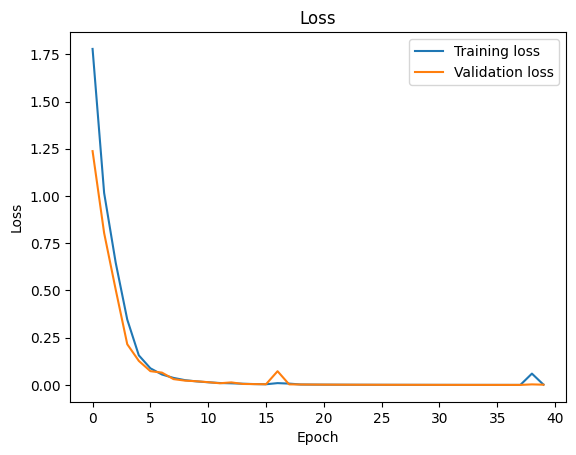

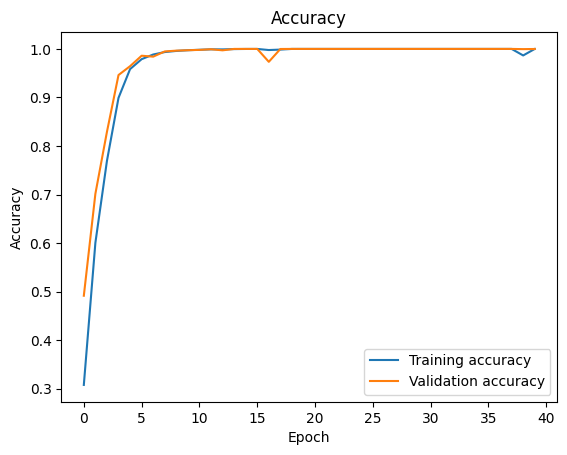

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['masked_accuracy'], label='Training accuracy')
plt.plot(history.history['val_masked_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From both the accuracy and loss plots, we can see that after only 40 epochs, the model achieves excellent performance without showing signs of overfitting on the training data.

In this case, early stopping is not even necessary to prevent it.

# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [6]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

Evaluate the model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

The model takes as input the expression in infix format and return its translation to postifix.

The generation is done autoregressively, beacause we are using an encoder-decoder model.

In [7]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]

      # autoregressive decode
      generated = autoregressive_decode(model_att, encoder_input)[1:]


      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

Let's test the model to determine if the training has obtained good weights.

In [10]:
res, std = test(20,10)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


# Saving weights of the model on drive



Mount the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Save the weights (overwrite the file only if the model has reached better performance)

In [ ]:
save_folder = '/content/drive/MyDrive/DeepLearning/'
model_att.save_weights(save_folder + 'infix_to_postfix_e32u28_francesco_giordani.weights.h5')
print(f"Weights saved to:\n  {save_folder}infix_to_postfix_e32u28_francesco_giordani.weights.h5")


Weights saved to:
  /content/drive/MyDrive/DeepLearning/infix_to_postfix_e32u28_francesco_giordani.weights.h5


# Download with gdown of model weights for evaluation


**This section can be used by the professor to test the performance obtained.**

Mount the drive.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use gdown to download the weights.

To run this cell you should have **run** before the **cells above** in the notebook, **except** the following sections:
- Training phase
- Saving weights of the model on drive

You have also to **decide** your own **download_path**!

In [9]:
!pip install --quiet gdown

import os
import gdown

DRIVE_FILE_ID = "1eYitz-OYAEBcyfWs6wqomefJnmIOfF1d"

# Choose your own download path
download_path = '/content/drive/MyDrive/DeepLearning/download/'

LOCAL_WEIGHTS_FILENAME = download_path+"infix_to_postfix_e32u28_francesco_giordani.weights.h5"

gdown.download(f"https://drive.google.com/uc?id={DRIVE_FILE_ID}", LOCAL_WEIGHTS_FILENAME, quiet=False)

model_att.load_weights(LOCAL_WEIGHTS_FILENAME)
print("model_att weights loaded.")

Downloading...
From: https://drive.google.com/uc?id=1eYitz-OYAEBcyfWs6wqomefJnmIOfF1d
To: /content/drive/MyDrive/DeepLearning/download/infix_to_postfix_e32u28_francesco_giordani.weights.h5
100%|██████████| 189k/189k [00:00<00:00, 44.6MB/s]

model_att weights loaded.



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test the model with the loaded weights

In [ ]:
res, std = test(20,10)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


# Conclusions

In line with Occam's razor concept, we have shown that a simple, well-structured model can achieve high accuracy without relying on complex training recipes. When the task and data allow, simplicity is not just sufficient, but optimal.